In [ ]:
!pip install langchain langchain_experimental langchain_openai langchain_Groq langgraph langchain_community langchain_core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 3.1 MB/s eta 0:00:00


In [ ]:
from typing import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage , HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langgraph.graph import StateGraph , START , END , MessagesState
from langchain_experimental.utilities import PythonREPL
from langgraph.types import Command

In [ ]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['GROQ_API_KEY'] = userdata.get("GROQ_API_KEY")

In [ ]:

groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b")
openai_model=ChatOpenAI(model="gpt-4")

In [ ]:
chat_groq.invoke("Hi").content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

In [ ]:
def add_number(state) :
  result = state['num1'] + state['num2']
  print(f"result : {result}")
  return Command(goto = 'multiply' , update={"sum":result})

In [ ]:
state={'num1':2 , 'num2':3}

In [ ]:

add_number(state)

result : 5


Command(update={'sum': 5}, goto='multiply')

In [ ]:
@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return

In [ ]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return

In [ ]:
model_with_tool = chat_openai.bind_tools([trasnfer_to_multiplication_expert])

In [ ]:
ai_message = model_with_tool.invoke("hi")

In [ ]:
ai_message.tool_calls

[]

In [ ]:
ai_message = model_with_tool.invoke("what's (3+5)*12 .provide me the output")

In [ ]:
ai_message.tool_calls

[{'name': 'trasnfer_to_multiplication_expert',
  'args': {},
  'id': 'call_1MH2XrL00CyyhaAw3A1nwCyx',
  'type': 'tool_call'}]

In [ ]:
def additional_expert(state:MessagesState)-> Command[Literal["multiplication_expert", "__end__"]]:

    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )

    messages = [{"role": "system", "content": system_prompt}] + state["messages"]


    ai_msg = openai_model.bind_tools([transfer_to_multiplication_expert]).invoke(messages)


    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }

        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

In [ ]:
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:

    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )

    messages = [{"role": "system", "content": system_prompt}] + state["messages"]

    ai_msg = openai_model.bind_tools([transfer_to_addition_expert]).invoke(messages)

    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [ ]:
workflow = StateGraph(MessagesState)

In [ ]:
workflow.add_node('additional_expert' , additional_expert)
workflow.add_node('multiplication_expert' , multiplication_expert)

In [ ]:
workflow.add_edge(START, 'additional_expert')

In [ ]:
graph = workflow.compile()

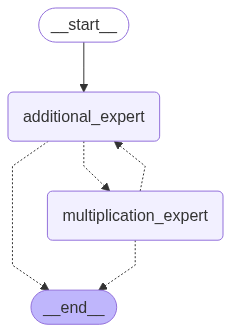

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"messages":[("user","what's (3 + 5) * 12. Provide me the output")]})

{'messages': [HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='55244403-0c3a-45ba-9264-3b422ccf618e'),
  AIMessage(content="The addition part of the operation is (3 + 5) = 8. Now let's ask the multiplication expert to multiply 8 by 12.", additional_kwargs={'tool_calls': [{'id': 'call_6RJ75jC3iKE308M7gJgXvPDV', 'function': {'arguments': '{\n  "multiplicand": 8,\n  "multiplier": 12\n}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 86, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-CDpiPneKjWX61DJh31li12mNLzuUK', 'service_tier': 'default', 'finish_reason': 'too

In [ ]:
@tool
def transfer_to_travel_advisor():
    """Ask travel advisor for help."""
    return
@tool
def transfer_to_hotel_advisor():
    """Ask hotel advisor for help."""
    return

In [ ]:
def travel_advisor(state: MessagesState) -> Command[Literal["hotel_advisor", "__end__"]]:
    system_prompt = (
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need hotel recommendations, ask 'hotel_advisor' for help."
    )

    messages = [{"role": "system", "content": system_prompt}] + state["messages"]

    ai_msg = groq_model.bind_tools([transfer_to_hotel_advisor]).invoke(messages)

    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }

        return Command(goto="hotel_advisor", update={"messages": [ai_msg, tool_msg]})

    return {"messages": [ai_msg]}

In [ ]:
def hotel_advisor(state: MessagesState) -> Command[Literal["travel_advisor", "__end__"]]:
    system_prompt = (
        "You are a hotel expert that can provide hotel recommendations for a given destination. "
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = groq_model.bind_tools([transfer_to_travel_advisor]).invoke(messages)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="travel_advisor", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [ ]:
graph_builder = StateGraph(MessagesState)

In [ ]:
graph_builder.add_node("travel_advisor", travel_advisor)
graph_builder.add_node("hotel_advisor", hotel_advisor)

In [ ]:
graph_builder.add_edge(START, "travel_advisor")

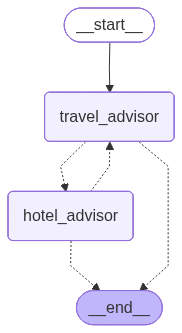

In [ ]:
app = graph_builder.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
app.invoke({"messages":[("user","I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel?")]})

{'messages': [HumanMessage(content='I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel?', additional_kwargs={}, response_metadata={}, id='2357c5fd-99aa-44dd-a8bb-d04361804959'),
  AIMessage(content="To plan your trip from Mumbai to California, follow this organized approach:\n\n### 1. **Travel Options from Mumbai to California**\n   - **Departure Airport**: Fly from Chhatrapati Shivaji Maharaj International Airport (BOM) in Mumbai.\n   - **Destination Airports**: Consider flying to Los Angeles (LAX), San Francisco (SFO), or San Diego (SAN) based on your interests.\n   - **Airlines**: Check options with Air India, Emirates, Qatar Airways, and American Airlines. Use flight comparison sites like Google Flights or Skyscanner for deals.\n\n### 2. **Travel Documents**\n   - **Visa Requirements**: Apply for a US tourist visa. Complete the DS-160 form, pay the fee, and schedule an interview at the US embassy or consulate

In [ ]:
from langchain_core.messages import convert_to_messages
def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")

    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")

        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")

In [ ]:

for chunk in app.stream(
    {"messages": [("user", "I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel?")]},
):
    print("****chunk****")

    pretty_print_messages(chunk)

****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================

Certainly! For travel options from Mumbai to California, you can fly from Chhatrapati Shivaji Maharaj International Airport (BOM) to major Californian airports like Los Angeles International Airport (LAX) or San Francisco International Airport (SFO). Airlines such as Air India, United, and Delta offer direct or connecting flights. Once in California, you can explore destinations like Los Angeles, San Francisco, San Diego, or Sacramento. For transportation, consider renting a car or using public transit like BART or Metro.
Tool Calls:
  transfer_to_hotel_advisor (z41vfsb6x)
 Call ID: z41vfsb6x
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk****
Update from node hotel_advisor:


================================== Ai Message ==================================
Tool Calls:
  transfer_

In [ ]:
for chunk in app.stream(
    {"messages": [("user", "What are the best flight options for Islamabad to California, and can you recommend top hotels for a comfortable and convenient stay?")]},
):
    print("****chunk****")

    pretty_print_messages(chunk)

****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_hotel_advisor (0zy90jjcb)
 Call ID: 0zy90jjcb
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk****
Update from node hotel_advisor:


================================== Ai Message ==================================

Sure! For flight options from Islamabad to California, I recommend checking with major airlines like Emirates, Qatar Airways, or Turkish Airlines, as they often offer convenient connections through their hubs. For the best deals and schedules, compare prices on platforms like Expedia, Skyscanner, or directly on airline websites.

For hotels in California, here are some top recommendations:

### Los Angeles:
1. **The Ritz-Carlton, Los Angeles** - Luxurious stay with great city views.
2. **The Beverly Hills Hotel** - Iconic and elegant, perfect fo